In [14]:
import numpy as np
from itertools import combinations
from numpy.polynomial import Polynomial
import matplotlib.pyplot as plt
import pandas as pd

### **Part 1: The Theory of Hermite Interpolation**



#### **A. The Core Concept: Matching Both Value and Slope**

*   **Problem Statement:** Given $n+1$ points $(x_0, y_0), \dots, (x_n, y_n)$ AND their corresponding derivatives $(x_0, y'_0), \dots, (x_n, y'_n)$, we want to find a polynomial $p(x)$ such that for each point $x_k$:
    1.  $p(x_k) = y_k$ (matches the value)
    2.  $p'(x_k) = y'_k$ (matches the derivative/slope)
*   **Degree:** Since we have $2(n+1)$ total pieces of information (a value and a derivative for each of the $n+1$ points), the resulting polynomial will have a degree of at most $2n+1$.

#### **B. The Two Types of Basis Polynomials**

*   **Theory:** The final polynomial is constructed as a weighted sum, similar to Lagrange, but with two sets of basis functions: $h_k(x)$ and $\hat{h}_k(x)$.
    
    $$ p_{2n+1}(x) = \sum_{k=0}^{n} \left[ y_k h_k(x) + y'_k \hat{h}_k(x) \right] $$
*   **The Magic Properties:** These basis polynomials are designed with even more specific properties than the Lagrange ones:
    *   **Value Basis ($h_k(x)$):**
        *   $h_k(x_k) = 1$ (its value is 1 at its "home" point)
        *   $h_k(x_j) = 0$ for all other points $j \neq k$
        *   $h'_k(x_j) = 0$ for **all** points, including $j=k$ (its slope is zero at all nodes)
    *   **Derivative Basis ($\hat{h}_k(x)$):**
        *   $\hat{h}_k(x_j) = 0$ for **all** points (its value is zero at all nodes)
        *   $\hat{h}'_k(x_k) = 1$ (its slope is 1 at its "home" point)
        *   $\hat{h}'_k(x_j) = 0$ for all other points $j \neq k$
*   **Why it works:** When you evaluate $p(x)$ at $x_k$, all terms drop out except for $y_k \cdot h_k(x_k) = y_k \cdot 1$. When you evaluate the derivative $p'(x)$ at $x_k$, all terms drop out except for $y'_k \cdot \hat{h}'_k(x_k) = y'_k \cdot 1$. It's a beautifully designed system.

#### **C. The Formulas (using Lagrange basis $l_k(x)$)**

*   **Foundation:** The Hermite basis functions are built using the Lagrange basis polynomials, $l_k(x)$, and their derivatives, $l'_k(x)$.
    
    $$ l_k(x) = \prod_{j=0, j\neq k}^{n} \frac{x-x_j}{x_k-x_j} $$
*   **Value Basis Formula ($h_k(x)$):**
    $$ h_k(x) = \left(1 - 2(x - x_k) l'_k(x_k)\right) \cdot l_k^2(x) $$
*   **Derivative Basis Formula ($\hat{h}_k(x)$):**
    $$ \hat{h}_k(x) = (x - x_k) \cdot l_k^2(x) $$

---

### **Part 2: The Implementation**

#### **A. The `l(k, x)` Function**

In [4]:
def l(k, x):
  n = len(x)
  assert (k < len(x))

  x_k = x[k]
  x_copy = np.delete(x, k)

  denominator = np.prod(x_copy - x_k)

  coeff = []

  for i in range(n):
    coeff.append(sum([np.prod(x) for x in combinations(x_copy, i)]) * (-1)**(i) / denominator)

  coeff.reverse()

  return Polynomial(coeff)

#### **B. The `h(k, x)` Function - The Value Basis Builder**

In [5]:
def h(k, x):
  """
    Calculates the k-th Hermite value basis polynomial, h_k(x).
    Formula: h_k(x) = (1 - 2(x - x_k) * l'_k(x_k)) * l_k^2(x)

    Args:
      k (int): The index of the basis polynomial.
      x (list or np.ndarray): The array of x-coordinates for all nodes.

    Returns:
      (numpy.polynomial.Polynomial): A Polynomial object representing h_k(x).
  """

  l_k = l(k, x) # Get the k-th Lagrange basis polynomial, l_k(x), as a Polynomial object.

  l_k_sqr = l_k**2 # Square the Lagrange polynomial: l_k^2(x).

  l_k_prime = l_k.deriv(1) # Get the derivative of the Lagrange polynomial: l'_k(x).

  m = l_k_prime(x[k]) # Evaluate the derivative at the specific point x_k to get the scalar slope, m.

  #________________________________________________________________________________________________________________________

  # Construct the linear polynomial part:
    # (1 - 2(x - x_k)m) = (1 + 2x_k * m) + (-2x * m)

    # Let coefficients c0 = (1 + 2x_k * m) and c1 = (-2 * m)

  # Its form is c1*x + c0, where coefficients are passed as [c0, c1].

  c0 = 1 + 2 * x[k] * m
  c1 = -2 * m

  coeff = [c0, c1]

  p = Polynomial(coeff)

  return p * l_k_sqr # Multiply the two polynomial parts to get the final h_k(x).


In [6]:
# --- Test case for the h(k, x) function ---
x_test_h = [3, 5, 7, 9]
k_test_h = 2

# Our function's output
h_test_result = h(k_test_h, x_test_h)
print("--- Our Calculated h_2(x) ---")
print(h_test_result)

# The lab's expected result for verification
l_k_for_h = l(k_test_h, x_test_h)
h_expected_result = Polynomial([-2.5, 0.5]) * (l_k_for_h ** 2)
print("\n--- Expected h_2(x) ---")
print(h_expected_result)

# --- Verification ---
assert h_expected_result == h_test_result, "The calculated polynomial does not match the expected result."
print("\nSuccess! The h(k, x) function is correct.")

--- Our Calculated h_2(x) ---
-177.97851562 + 264.99023438·x - 164.61914062·x² + 55.27148438·x³ -
10.82617188·x⁴ + 1.23632812·x⁵ - 0.07617188·x⁶ + 0.00195312·x⁷

--- Expected h_2(x) ---
-177.97851562 + 264.99023438·x - 164.61914062·x² + 55.27148438·x³ -
10.82617188·x⁴ + 1.23632812·x⁵ - 0.07617188·x⁶ + 0.00195312·x⁷

Success! The h(k, x) function is correct.


#### **C. The `h_hat(k, x)` Function - The Derivative Basis Builder**

In [9]:
def h_hat(k, x):
  """
    Calculates the k-th Hermite derivative basis polynomial, h_hat_k(x).
    Formula: h_hat_k(x) = (x - x_k) * l_k^2(x)

    Args:
      k (int): The index of the basis polynomial.
      x (list or np.ndarray): The array of x-coordinates for all nodes.

    Returns:
      (numpy.polynomial.Polynomial): A Polynomial object representing h_hat_k(x).
  """

  l_k = l(k, x) # Get the k-th Lagrange basis polynomial, l_k(x), as a Polynomial object.

  l_k_sqr = l_k ** 2 # Square the Lagrange polynomial: l_k^2(x).

  # Construct the linear polynomial part: (x - x_k). Its form is c1*x + c0, where coefficients are passed as [c0, c1].

  c0 = -x[k]
  c1 = 1

  coeff = [c0, c1]

  p = Polynomial(coeff)

  return p * l_k_sqr # Multiply the two polynomial parts to get the final h_hat_k(x).

In [10]:
# --- Test case for the h_hat(k, x) function ---
x_test_h_hat = [3, 5, 7, 9]
k_test_h_hat = 2

# Our function's output
h_hat_test_result = h_hat(k_test_h_hat, x_test_h_hat)
print("--- Our Calculated h_hat_2(x) ---")
print(h_hat_test_result)

# The lab's expected result for verification
l_k_for_h_hat = l(k_test_h_hat, x_test_h_hat)
h_hat_expected_result = Polynomial([-7, 1]) * (l_k_for_h_hat ** 2)
print("\n--- Expected h_hat_2(x) ---")
print(h_hat_expected_result)

# --- Verification ---
assert h_hat_expected_result == h_hat_test_result, "The calculated polynomial does not match the expected result."
print("\nSuccess! The h_hat(k, x) function is correct.")

--- Our Calculated h_hat_2(x) ---
-498.33984375 + 713.49609375·x - 424.23046875·x² + 135.76171875·x³ -
25.26953125·x⁴ + 2.73828125·x⁵ - 0.16015625·x⁶ + 0.00390625·x⁷

--- Expected h_hat_2(x) ---
-498.33984375 + 713.49609375·x - 424.23046875·x² + 135.76171875·x³ -
25.26953125·x⁴ + 2.73828125·x⁵ - 0.16015625·x⁶ + 0.00390625·x⁷

Success! The h_hat(k, x) function is correct.


#### **D. The `hermit(x, y, y_prime)` Function - The Assembler**

In [11]:
def hermit(x, y, y_prime):
  """
    Constructs the Hermite interpolating polynomial.

    Args:
      x (list or np.ndarray): The x-coordinates of the data points.
      y (list or np.ndarray): The y-coordinates (function values) of the data points.
      y_prime (list or np.ndarray): The derivative values at the data points.

    Returns:
      (numpy.polynomial.Polynomial): The final Hermite interpolating polynomial object.
  """
  assert len(x) == len(y), "x and y must have the same length."
  assert len(y) == len(y_prime), "y and y_prime must have the same length."

  # We need a polynomial object to store our sum. We start with the polynomial for the function f(x)=0.
  # The Polynomial class can be initialized with a list of coefficients; [0] represents the zero polynomial.

  f = Polynomial([0]) # Initialize an accumulator polynomial f(x) = 0

  # Loop through each data point k from 0 to n
  for k in range(len(x)):

    # Calculate the two basis polynomials for the k-th point
    h_k = h(k, x)

    h_k_hat = h_hat(k, x)

    f += y[k] * h_k + y_prime[k] * h_k_hat # Add the weighted basis functions to the total polynomial. This performs the summation.

  return f

In [12]:
# --- Test case for the hermit() function using data from Plot 5 ---

# Define the node information: x, y, and y'
x_plot5 = np.array([1.0, 3.0, 5.0])
y_plot5 = np.array([5.0, 1.0, 5.0])
y_prime_plot5 = np.array([-4.0, 0.0, 4.0])

# Construct the Hermite polynomial
p_hermite = hermit(x_plot5, y_plot5, y_prime_plot5)

print("--- The Final Hermite Polynomial ---")
print(p_hermite)

# --- Verification ---
# The original function is f(x) = (x-3)^2 + 1 = x^2 - 6x + 9 + 1 = x^2 - 6x + 10
# The coefficients [c0, c1, c2] should be [10, -6, 1]
expected_coeffs = np.array([10., -6., 1.])

# Get the coefficients from our result. We use .coef attribute from the Polynomial object.
# We need to round them to handle tiny floating point inaccuracies.
calculated_coeffs = np.round(p_hermite.coef, decimals=5)

print("\nExpected Coefficients:", expected_coeffs)
print("Calculated Coefficients:", calculated_coeffs)

np.testing.assert_array_almost_equal(calculated_coeffs, expected_coeffs)
print("\nSuccess! The hermit() function correctly constructed the polynomial.")

# Further verification: check if values and derivatives match at the nodes
print("\n--- Verifying conditions at the nodes ---")
print("Polynomial values at nodes:", p_hermite(x_plot5))
print("Original y-values at nodes:", y_plot5)
print("\nPolynomial derivatives at nodes:", p_hermite.deriv()(x_plot5))
print("Original y'-values at nodes:", y_prime_plot5)

--- The Final Hermite Polynomial ---
10.0 - 6.0·x + 1.0·x²

Expected Coefficients: [10. -6.  1.]
Calculated Coefficients: [10. -6.  1.]

Success! The hermit() function correctly constructed the polynomial.

--- Verifying conditions at the nodes ---
Polynomial values at nodes: [5. 1. 5.]
Original y-values at nodes: [5. 1. 5.]

Polynomial derivatives at nodes: [-4.  0.  4.]
Original y'-values at nodes: [-4.  0.  4.]


### **Problem solving & plotting: Hermite Interpolation for cos(x)**

Suppose you are given nodes sampled from the function $f(x) = \cos(x)$ and its derivative $f'(x) = -\sin(x)$. The given nodes are:

| x        | -π/2 | 0 | π/2 |
| :------- | :--- | :-| :--- |
| y        | 0    | 1 | 0    |
| y_prime  | 1    | 0 | -1   |

Using your implementation of the Hermite interpolation method:

1.  **Find the Interpolated Polynomial:** Construct the Hermite interpolating polynomial, $p(x)$, that fits this data. Print the resulting polynomial object.
2.  **Calculate a Value:** Calculate and print the value of the interpolating polynomial at $x = \pi/3$. Also, print the true value of $\cos(\pi/3)$ for comparison.
3.  **Plot:** Plot both the interpolated polynomial $p(x)$ and the original function $\cos(x)$ over the interval $[-3, 3]$ to visually compare the fit.

--- 1. The Interpolating Polynomial ---
1.0 + 0.0·x - 0.49226·x² + 0.0·x³ + 0.03525·x⁴

--- 2. Value Calculation ---
Value of interpolated polynomial p(pi/3) is: 0.502567
                 True value of cos(pi/3) is: 0.500000
                             Absolute Error: 0.002567

--- 3. Generating Plot ---


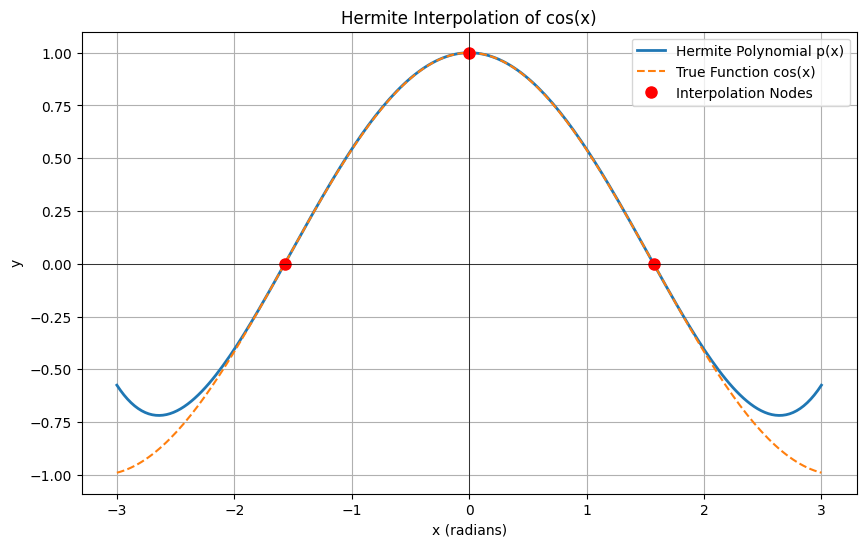

In [19]:
# --- Step 0: Define the given data ---
x_nodes = np.array([-np.pi/2, 0, np.pi/2])
y_nodes = np.array([0.0, 1.0, 0.0])
y_prime_nodes = np.array([1.0, 0.0, -1.0])

# --- Step 1: Find the Interpolated Polynomial ---
p_hermite_cos = hermit(x_nodes, y_nodes, y_prime_nodes)
p_hermite_cos.coef = np.round(p_hermite_cos.coef, 5) # We round the coefficients for a cleaner printout

print("--- 1. The Interpolating Polynomial ---")
print(p_hermite_cos)

# --- Step 2: Calculate the value at x = pi/3 ---
x_eval = np.pi/3
p_value = p_hermite_cos(x_eval)
true_value = np.cos(x_eval)

print(f"\n--- 2. Value Calculation ---")
print(f"Value of interpolated polynomial p(pi/3) is: {p_value:.6f}")
print(f"                 True value of cos(pi/3) is: {true_value:.6f}")
print(f"                             Absolute Error: {abs(p_value - true_value):.6f}")


# --- Step 3: Plot the functions ---
x_plot = np.linspace(-3, 3, 200) # Generate a dense set of x-values for smooth curves

y_plot_hermite = p_hermite_cos(x_plot) # Calculate y-values for both the polynomial and the true function
y_plot_true_cos = np.cos(x_plot)

print("\n--- 3. Generating Plot ---")
plt.figure(figsize=(10, 6))

# Plot the Hermite polynomial
plt.plot(x_plot, y_plot_hermite, label='Hermite Polynomial p(x)', linewidth=2)

# Plot the true cos(x) function
plt.plot(x_plot, y_plot_true_cos, label='True Function cos(x)', linestyle='--')

# Plot the original nodes to show the fit
plt.plot(x_nodes, y_nodes, 'ro', label='Interpolation Nodes', markersize=8)

# Add title, labels, and grid
plt.title("Hermite Interpolation of cos(x)")
plt.xlabel("x (radians)")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)

# Show the plot
plt.show()